<a href="https://colab.research.google.com/github/s-c-soma/AdvanceDeeplearning-CMPE-297/blob/master/Assignment_1_%20Part_2/Assignment1_part2_SemisupervisedLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Semi Supervised Learning

# Implementation Details and Discussion

**Semi-supervised** is an machine learning approach that deals with both label and unlabeled data. The amount of labeled data is very less compared to unlabeled data. So Semi-supervised learning belongs to both unsupervised and supervised learning

**Implementation**

Semi supervised learning methods actually use the unlabeled data to modify or to change the priority of the data obtained from labeled data. Some methods are probabilistics also. We get a joint distribution for that.  Original discriminative methods can not be used here for semi supervised problems.


As mentioned above, semi supervised learning is a combination of supervised and unsupervised. So at first I loaded the Mnist. It is a labeled data. I have taken 20% of the labeled data. For the rest of the 80% data, I have removed the label and made it ready for unsupervised. Assigned label -1 for that. Finally I have defined the network, trained the model. This model performs with 92% accuracy. The last section visualizes the prediction of the model. 
 

# Using Mnist Data

In [58]:
from __future__ import print_function
import pickle 
import numpy as np
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from scipy import ndimage
from scipy import misc

import tensorflow as tf
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
import torchvision


## Parameters Definition 

In [50]:
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

## Load Mnist

In [59]:
init_dataset =  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))


val_dataset = torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))

In [52]:
len(init_dataset)


60000

## Spliting data for semi-supervised [20% labeled + 80% unlabeled]

In [53]:
lengths = [int(len(init_dataset)*0.2), int(len(init_dataset)*0.8)]
labeled_subsetA, unlabeled_subsetB = random_split(init_dataset, lengths)



train_unlabeled_data = [(unlabeled_subsetB[i][0],-1) for i in range(len(unlabeled_subsetB))]
len(train_unlabeled_data)

48000

In [60]:
def get_data_loaders(train_labeled_data, train_unlabeled_data, test_data, train_batch_size, val_batch_size):
    train_loader = DataLoader(train_labeled_data, batch_size=train_batch_size, shuffle=True)
    train_unlabeled_loader = DataLoader(train_unlabeled_data, batch_size=train_batch_size, shuffle=True)
    val_loader = DataLoader(test_data, batch_size=val_batch_size, shuffle=False,)



    return train_loader,train_unlabeled_loader, val_loader

In [61]:
batch_size_train = 64
batch_size_test = 1000

train_labeled_loader2,train_unlabeled_loader2,val_loader2 =  get_data_loaders(labeled_subsetA, train_unlabeled_data,val_dataset, batch_size_train, batch_size_test)

In [62]:
batch1 = next(iter(train_loader))
print(batch1[0].shape)
print(batch1[1].shape)
len(batch1)

torch.Size([64, 1, 28, 28])
torch.Size([64])


2

In [63]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

## Defing Network

In [64]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [65]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

In [66]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(val_loader2.dataset) for i in range(n_epochs + 1)]

## Training

In [68]:
num_cycles = 20
# training
def train2(epoch=10):
    network.train()
    
    #pre-training without unlabeled data 
    if epoch > num_cycles:
        for batch_idx, (data, target) in enumerate(train_unlabeled_loader2):
            network.eval()
            output = network(data)
            fake_target = (output.data.max(1)[1].view(-1)) # using pseudo label method and get pseudo labels
            network.train()
            #data.volatile = False
            optimizer.zero_grad()
            output = network(data)
            loss = F.nll_loss(output, fake_target)
            loss.backward()
            optimizer.step()
            if batch_idx % 10 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_unlabeled_loader2.dataset),
                    100. * batch_idx / len(train_unlabeled_loader2), loss.item()))

    avg_train_loss = 0
    for batch_idx, (data, target) in enumerate(train_labeled_loader2):
        
        
        optimizer.zero_grad()
        output = network(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_labeled_loader2.dataset),
                100. * batch_idx / len(train_labeled_loader2), loss.item()))
            avg_train_loss += loss.item()
            train_losses.append(loss.item())
            train_counter.append(
              (batch_idx*64) + ((epoch-1)*len(train_labeled_loader2.dataset)))
     
    avg_train_loss = avg_train_loss / (len(train_labeled_loader2) / 500)
    #loss_compare.write(str(avg_train_loss) + ',') # no need for now



In [69]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in val_loader2: #modifing it : test_loader
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(val_loader2.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(val_loader2.dataset),
    100. * correct / len(val_loader2.dataset)))

## Network Training

In [70]:
#test()-- don't use this
for epoch in range(1, n_epochs + 1):
  train2(epoch)
  test()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 1 [0/12000 (0%)]	Loss: 2.356843
Train Epoch: 1 [640/12000 (5%)]	Loss: 2.283128
Train Epoch: 1 [1280/12000 (11%)]	Loss: 2.303393
Train Epoch: 1 [1920/12000 (16%)]	Loss: 2.308585
Train Epoch: 1 [2560/12000 (21%)]	Loss: 2.289832
Train Epoch: 1 [3200/12000 (27%)]	Loss: 2.247993
Train Epoch: 1 [3840/12000 (32%)]	Loss: 2.217648
Train Epoch: 1 [4480/12000 (37%)]	Loss: 2.209392
Train Epoch: 1 [5120/12000 (43%)]	Loss: 2.127865
Train Epoch: 1 [5760/12000 (48%)]	Loss: 2.147814
Train Epoch: 1 [6400/12000 (53%)]	Loss: 1.990887
Train Epoch: 1 [7040/12000 (59%)]	Loss: 1.939869
Train Epoch: 1 [7680/12000 (64%)]	Loss: 1.816510
Train Epoch: 1 [8320/12000 (69%)]	Loss: 1.631183
Train Epoch: 1 [8960/12000 (74%)]	Loss: 1.695031
Train Epoch: 1 [9600/12000 (80%)]	Loss: 1.607823
Train Epoch: 1 [10240/12000 (85%)]	Loss: 1.252385
Train Epoch: 1 [10880/12000 (90%)]	Loss: 1.546888
Train Epoch: 1 [11520/12000 (96%)]	Loss: 1.331514


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.8873, Accuracy: 7999/10000 (80%)

Train Epoch: 2 [0/12000 (0%)]	Loss: 1.278169
Train Epoch: 2 [640/12000 (5%)]	Loss: 1.220971
Train Epoch: 2 [1280/12000 (11%)]	Loss: 1.021689
Train Epoch: 2 [1920/12000 (16%)]	Loss: 1.331441
Train Epoch: 2 [2560/12000 (21%)]	Loss: 1.103626
Train Epoch: 2 [3200/12000 (27%)]	Loss: 0.911389
Train Epoch: 2 [3840/12000 (32%)]	Loss: 1.097379
Train Epoch: 2 [4480/12000 (37%)]	Loss: 0.932774
Train Epoch: 2 [5120/12000 (43%)]	Loss: 1.023763
Train Epoch: 2 [5760/12000 (48%)]	Loss: 1.056321
Train Epoch: 2 [6400/12000 (53%)]	Loss: 0.913733
Train Epoch: 2 [7040/12000 (59%)]	Loss: 0.877066
Train Epoch: 2 [7680/12000 (64%)]	Loss: 0.827073
Train Epoch: 2 [8320/12000 (69%)]	Loss: 1.150973
Train Epoch: 2 [8960/12000 (74%)]	Loss: 0.919090
Train Epoch: 2 [9600/12000 (80%)]	Loss: 0.814670
Train Epoch: 2 [10240/12000 (85%)]	Loss: 0.679225
Train Epoch: 2 [10880/12000 (90%)]	Loss: 0.755622
Train Epoch: 2 [11520/12000 (96%)]	Loss: 0.881196

Test set: Avg

In [23]:
# fixing the shape issue
print(n_epochs)
len(test_losses)

len(test_counter)

3


4

In [25]:
with torch.no_grad():
  output = network(example_data)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


## Visualizing Accuracy and Prediction

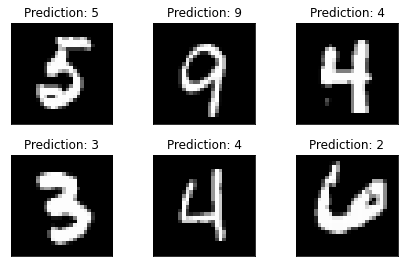

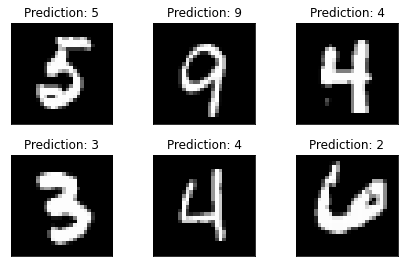

In [26]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])
fig